# Train Logistic Regression Models on KDDCup99

Steps of the process:
* Use of Scikit-learn's logistic regression model: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
* Download KDD99Cup dataset (http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html)
* Use the Sciket-learn library to train the Logistic regression model ( classify Probe vs Not Probe classes using avaible features.
  * Probe classes such as [ipsweep,nmap,portsweep,probe,etc..]
  * Non probe class consist of every other attack. 
* Note: Make sure split data into train and test sets. In general 80 (training) - 20 ( test)


* Summarize results:  What is the training accuracy? Do you think your model outfits? How many iteration did it take to converge?
* Look at trainined model prameters. Whihc featurs largest weights in absolute value? These are potenially most informative features for training model. Do they make sense why?

* Train model with L1 and L2 regularization. Compare accuracies for L1 and L2 and plot feature weights. 
* Try different strengths for L2 regularization ( use values 0.001, 0.01, 0.1, 1, 10, etc.). Show how train and test accuracy varies with different regularization strengths. Explain your results. 

In [9]:
import numpy as np
import os # this is info about the library/method used https://docs.python.org/3/library/os.path.html
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.linear_model import LogisticRegression # importing the logistic regression model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline

from imblearn.under_sampling import RandomUnderSampler # For undersampling

## Looking at the KDD99Cup dataset

Note the 10% of the data is a good set to go with as it capture a pretty big dataset by it self (2.1M lines) 

In [11]:
# URL for the 10% sample dataset
url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"

# Load the dataset (no column names in the raw file)
df = pd.read_csv(url, compression='gzip', header=None)

# Display the first 5 rows
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
494016,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.
494020,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.


Just for some reference, lets look at the size of the file

In [13]:
print(df.memory_usage(deep=True).sum(), "bytes")
df.shape

271545193 bytes


(494021, 42)

In [14]:
#Remote duplicated values 
df.drop_duplicates(inplace=True)
print(df.memory_usage(deep=True).sum(), "bytes")
df.shape

81226500 bytes


(145586, 42)

### Lets get the features from KDD99Cup to set up data properly

In [16]:

# Path to the downloaded file
names_file_path = "kiddcup_names.txt"

# Read feature names from the file
feature_names = []
with open(names_file_path, "r") as f:
    for line in f.readlines()[1:]:  # Skip the first line (it describes the class label - these are the classes)
        feature_names.append(line.split(":")[0])  # Extract only the feature name

# Add the label column at the end
feature_names.append("intrusion_types")

# Print the final feature list
df.columns = feature_names # match column names
df.head()  # Check if column names are applied correctly

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion_types
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [18]:
# This will be for the features
print(feature_names, len(feature_names))

['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'intrusion_types'] 42


In [19]:
output = df['intrusion_types'].values
labels = set(output)
len(labels)

23

In [20]:
# Want to see what the class_level column looks like as a graph

# Check unique values in the last column (assuming it contains attack labels)
print(df.iloc[:, -1].value_counts())


normal.             87832
neptune.            51820
back.                 968
teardrop.             918
satan.                906
warezclient.          893
ipsweep.              651
smurf.                641
portsweep.            416
pod.                  206
nmap.                 158
guess_passwd.          53
buffer_overflow.       30
warezmaster.           20
land.                  19
imap.                  12
rootkit.               10
loadmodule.             9
ftp_write.              8
multihop.               7
phf.                    4
perl.                   3
spy.                    2
Name: intrusion_types, dtype: int64


### Lets take a look at initial visualizations of the current data we got

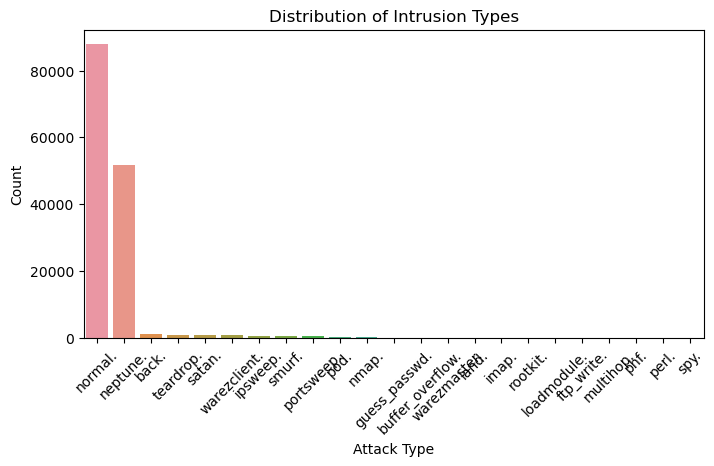

In [22]:
import seaborn as sns # using seaborn for visualization

# Count occurrences of each class label
plt.figure(figsize=(8, 4))
sns.countplot(x=df["intrusion_types"], order=df["intrusion_types"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribution of Intrusion Types")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.show() #Shows how imbalanced the dataset is as if one class dominates, causing issues with 
# logistic regression set up

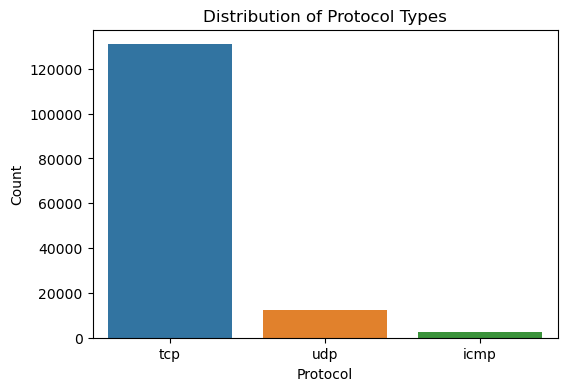

In [23]:
# Visualize the protocol type usage as well
plt.figure(figsize=(6, 4))
sns.countplot(x=df["protocol_type"], order=df["protocol_type"].value_counts().index)
plt.title("Distribution of Protocol Types")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.show() # To show the common network protocols used in the dataset

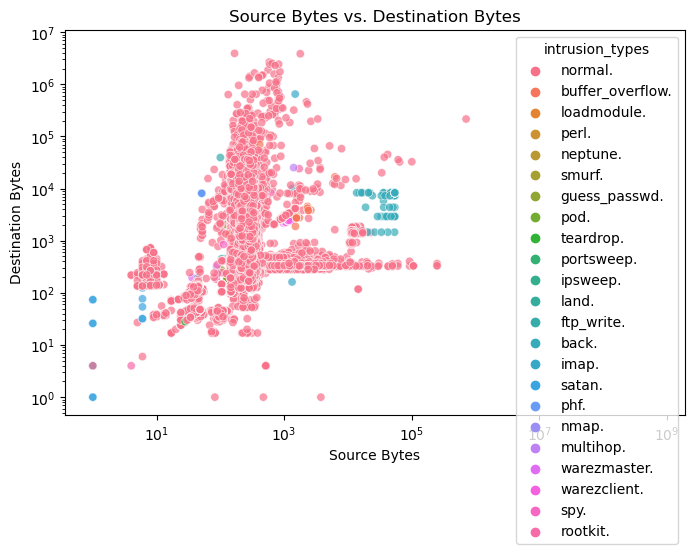

In [24]:
# Look at scatter plot of the features 
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["src_bytes"], y=df["dst_bytes"], hue=df["intrusion_types"], alpha=0.7)
plt.xscale("log")  # Log scale for better visualization
plt.yscale("log")
plt.title("Source Bytes vs. Destination Bytes")
plt.xlabel("Source Bytes")
plt.ylabel("Destination Bytes")
plt.show() # this tells attacks that may cause huge amounts of data while others nothing


## Gathering the training and testing examples from data.

The rule of thump is 80% of data is for training and 20% is for testing as a good split. 

Other important thing to note:
 * The Logistic Regression model is to classify Probe vs Non Probe classes using all available features.
 * Class 1: Probe class ( all probing attacks - ipsweep probe, nmap probe, portsweep probe, etc.)
 * Class 2: Non-probe class ( every other attack in dataset)
 
Side note:
Attacks fall into four main categories:

* DOS: denial-of-service, e.g. syn flood;
* R2L: unauthorized access from a remote machine, e.g. guessing password;
* U2R:  unauthorized access to local superuser (root) privileges, e.g., various ``buffer overflow'' attacks;
* probing: surveillance and other probing, e.g., port scanning.

In [26]:
# Getting the Attacks line from data set first

with open(names_file_path, "r") as f:
    # Read the first line, which contains attack types info
    attack_line = f.readline().strip()
attack_types = attack_line.split(",")  # Adjust the delimiter if necessary
attack_types, len(attack_types)

attack_types

['back',
 'buffer_overflow',
 'ftp_write',
 'guess_passwd',
 'imap',
 'ipsweep',
 'land',
 'loadmodule',
 'multihop',
 'neptune',
 'nmap',
 'normal',
 'perl',
 'phf',
 'pod',
 'portsweep',
 'rootkit',
 'satan',
 'smurf',
 'spy',
 'teardrop',
 'warezclient',
 'warezmaster.']

In [27]:
# List of probe attack types (with trailing periods)
probe_types = ['ipsweep.', 'nmap.', 'portsweep.', 'satan.', 'warezclient.', 'warezmaster.']

def classify_probe(row):
    return "Probe" if row in probe_types else "Non-Probe"

# Apply the classification function to the label column
df['class_label'] = df['intrusion_types'].apply(classify_probe)

# Verify if probe attacks are now labeled correctly
print(df['class_label'].value_counts())
print(df['intrusion_types'].value_counts())

Non-Probe    142542
Probe          3044
Name: class_label, dtype: int64
normal.             87832
neptune.            51820
back.                 968
teardrop.             918
satan.                906
warezclient.          893
ipsweep.              651
smurf.                641
portsweep.            416
pod.                  206
nmap.                 158
guess_passwd.          53
buffer_overflow.       30
warezmaster.           20
land.                  19
imap.                  12
rootkit.               10
loadmodule.             9
ftp_write.              8
multihop.               7
phf.                    4
perl.                   3
spy.                    2
Name: intrusion_types, dtype: int64


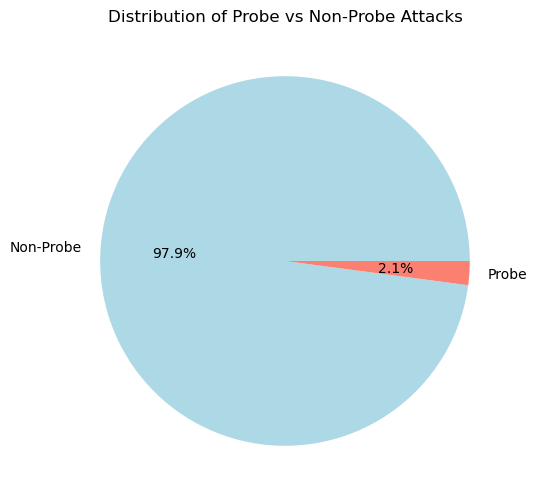

In [28]:
# Count the number of occurrences of each class
class_counts = df['class_label'].value_counts()
# Calculate percentages
percentages = class_counts / class_counts.sum() * 100
# Plot a pie chart
plt.figure(figsize=(6, 6))
plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%', colors=['lightblue', 'salmon'])
plt.title('Distribution of Probe vs Non-Probe Attacks')
plt.show()

Now that we have done the Data Preprocessing of preparing data and label target classes ( Probe vs Non-Probe) we can move to split data into Training and Testing sets now

In [30]:
from sklearn.model_selection import train_test_split # using for data spliting process

# Lets split features (X) and target (y)
X = df.drop(columns=['class_label']) # All columns not class_label
y = df['class_label']

# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training Set Size: {len(X_train)}")
print(f"Testing Set Size: {len(X_test)}")



Training Set Size: 116468
Testing Set Size: 29118


## Process of encoding categorical data 

Goal: 
- To encode categorical datasets into One-Hot Encoding from Scikit-learn

In [32]:
# Finding out what features are categorical
print(df.dtypes)

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [33]:
# So Now we know targets are: protocol_type, service, flag, intrusion_types, and class_label
label_enc = LabelEncoder()
df['service'] = label_enc.fit_transform(df['service'])
df['intrusion_types'] = label_enc.fit_transform(df['intrusion_types'])

# Apply One-Hot Encoding for 'protocol_type', 'flag', and 'class_label'
df = pd.get_dummies(df, columns=['protocol_type', 'flag', 'class_label'], drop_first=True)
df.head()

,duration,service,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,class_label_Probe
0,0,22,181,5450,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0,22,239,486,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0,22,235,1337,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0,22,219,1337,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,22,217,2032,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


Now this part is dealing with the testing and training split of data

In [35]:
# Features (X) and target (y)
X = df.drop(columns=['class_label_Probe'])  # Drop target column
y = df['class_label_Probe']  # Target variable (0 = Non-Probe, 1 = Probe)

# Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



We need to add undersampling process here before going to training process so Wil use the Random UnderSampling 


In [37]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Fit the resampler to the training data
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# Check the class distribution after undersampling
print(f"Class distribution after undersampling: {y_train_res.value_counts()}")

Class distribution after undersampling: 0    2435
1    2435
Name: class_label_Probe, dtype: int64


## Training the Logistic Regression Model with the training data and test data

In [40]:
# Initialize logistic regression model
log_reg = LogisticRegression(max_iter=2000)  # Increase max_iter for convergence

# Train the model
log_reg.fit(X_train_res, y_train_res)

# Predictions
y_train_pred = log_reg.predict(X_train_res)
y_test_pred = log_reg.predict(X_test)

# Compute accuracies
train_acc = accuracy_score(y_train_res, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")
print(log_reg.n_iter_)

Training Accuracy: 0.9066
Testing Accuracy: 0.9141
[1703]


Note that from the results the model is
* Not overfitting
* training accuracy is 90.66%, and the testing accuracy is 91.41%. This indicates that the model generalizes well and can classify Probe vs. Non-Probe attacks with good accuracy.
* The model took 1703 iterations to converge, which is higher than the 1000 iterations initially set. This suggests that the model needed more time to optimize, indicating that either the regularization strength needs adjustment, or the data itself requires further preprocessing.

Possible Class Imbalancement:
* Probe attacks make up a small portion of the dataset (~2.1%), which leads to an imbalanced dataset. This imbalance means that accuracy alone doesn't provide a full picture of model performance.

So Lets look at other things like
* The model's precision and recall for classifying "Probe" attacks should be analyzed, as the model could be biased towards the majority class (Non-Probe) due to the imbalance.



In [42]:
# Classification Report for test data
print(classification_report(y_test, y_test_pred, target_names=["Not Probe", "Probe"]))

# Optionally, you can evaluate the training data as well:
print("Classification report for training data:")
print(classification_report(y_train_res, y_train_pred, target_names=["Not Probe", "Probe"]))

              precision    recall  f1-score   support

   Not Probe       1.00      0.91      0.95     28509
       Probe       0.18      0.90      0.31       609

    accuracy                           0.91     29118
   macro avg       0.59      0.91      0.63     29118
weighted avg       0.98      0.91      0.94     29118

Classification report for training data:
              precision    recall  f1-score   support

   Not Probe       0.90      0.92      0.91      2435
       Probe       0.92      0.90      0.91      2435

    accuracy                           0.91      4870
   macro avg       0.91      0.91      0.91      4870
weighted avg       0.91      0.91      0.91      4870



* This tells use that while accuracy is high, probe detection is weak meaning it is good at classifiying "Not Probe" but struggles with "Probe".
* 100% precision means that when model predicts Non Probe and out of al true Not Probe 91% is correctly identified.
* Recall eans model missed (1 - recall = 10%) of actual Probe attacks ( so low recal is bad in cybersecurity). This is cause of that 18% percision. 
* So tradeff between is, model is willing to label more instances as Probe even though false Positives in order to catch as many actual samples. 
* With accuracy of 91% for f1-score for both means not bias for one over other.


The model is good in the sense that it catches most of the true Probe instances (high recall), but it also raises a lot of false alarms (low precision).

If you are primarily concerned with catching attacks and minimizing false negatives, the model could be considered good. However, if you want to reduce false positives and have more confidence in each prediction, the model will need improvements, such as boosting precision for the Probe class.

## Overfitting

Note that since the accuracy of the 

## Lets look at the trained model parameters 

* This being largest weights in absolute value while also making sense of them and why

In [44]:
# Get feature weights
feature_importance = np.abs(log_reg.coef_[0])  # Absolute values of weights
feature_names = X.columns

# Sort features by importance
sorted_indices = np.argsort(feature_importance)[::-1]
top_features = [(feature_names[i], feature_importance[i]) for i in sorted_indices[:10]]

print("Top 10 Most Informative Features:")
for feature, weight in top_features:
    print(f"{feature}: {weight:.4f}")

Top 10 Most Informative Features:
intrusion_types: 0.4310
hot: 0.2159
dst_host_same_src_port_rate: 0.0385
same_srv_rate: 0.0257
flag_SF: 0.0221
dst_host_count: 0.0209
service: 0.0205
dst_host_srv_count: 0.0200
serror_rate: 0.0196
dst_host_serror_rate: 0.0195


From the analysis above, it is noticed that the feature weigths from largest 10 are shown abover with intrusion_types being the most. Now going one by one for the top 3, we can make sense of why it is:
* intrusion_types at 43.1% makes alot of sense b/c this feature likely represents the type of attack directly and probe attacks have intrusion types.
* hot at 21.6% deals with the number of system calls that could indicate attack. Since probe attacks require scanning and interacting with multiple services, makes sence. 
* dst_host_same_src_port_rate at 2.57%


These features are key in distinguishing between Probe and Not Probe behaviors.
intrusion_types seems to be the most indicative of an attack type, followed by other metrics related to server errors, connection patterns, and service interactions.

## Train Model with L1 and L2 regularization while comparing accuracies and plot feature weights

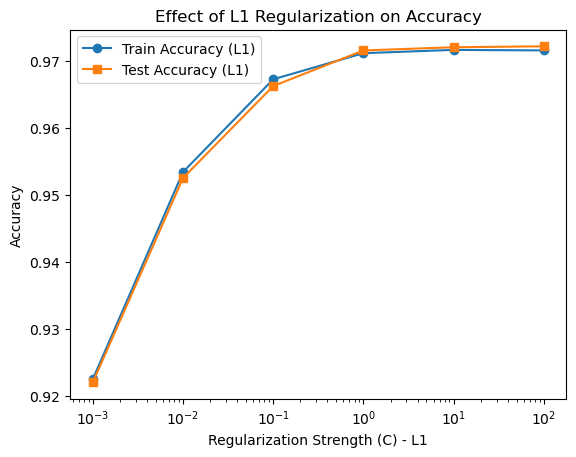

In [52]:
# Regularization strengths
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
train_accs_l1 = []
test_accs_l1 = []

# Use pipeline with scaling for L1 regularization
for C in C_values:
    pipe_lgr_l1 = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', C=C, solver='liblinear', max_iter=1704))
    pipe_lgr_l1.fit(X_train_res, y_train_res)
    
    train_accs_l1.append(pipe_lgr_l1.score(X_train, y_train))
    test_accs_l1.append(pipe_lgr_l1.score(X_test, y_test))

# Plot train vs test accuracy for L1 regularization
plt.plot(C_values, train_accs_l1, label="Train Accuracy (L1)", marker='o')
plt.plot(C_values, test_accs_l1, label="Test Accuracy (L1)", marker='s')
plt.xscale('log')  # Log scale for better visualization
plt.xlabel("Regularization Strength (C) - L1")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Effect of L1 Regularization on Accuracy")
plt.show()


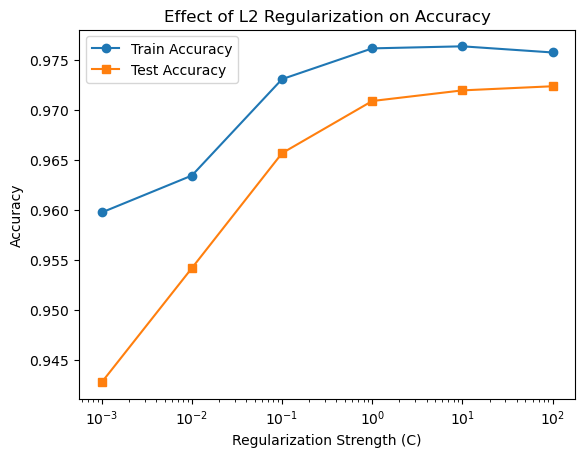

In [54]:
# Regularization strengths
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
train_accs = []
test_accs = []

# Use pipeline with scaling
for C in C_values:
    pipe_lgr_l2 = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', C=C, max_iter=1704))
    pipe_lgr_l2.fit(X_train_res, y_train_res)
    
    train_accs.append(pipe_lgr_l2.score(X_train_res, y_train_res))
    test_accs.append(pipe_lgr_l2.score(X_test, y_test))

# Plot train vs test accuracy
plt.plot(C_values, train_accs, label="Train Accuracy", marker='o')
plt.plot(C_values, test_accs, label="Test Accuracy", marker='s')
plt.xscale('log')  # Log scale for better visualization
plt.xlabel("Regularization Strength (C)")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Effect of L2 Regularization on Accuracy")
plt.show()

## Obervations of both L1 and L2 regularization from the feature weights 
L1 Regularization 
* This suggests that the model is generalizing well to the data, and the regularization helps prevent overfitting.
* Accuracy increases with increasing C values: This is typical as lower C values apply more regularization, reducing model complexity, and leading to lower accuracy. As you increase C, the model becomes less regularized, allowing it to fit the training data better, which often results in higher accuracy.
* Once you hit a certain regularization strength accuracy seems to level off and doesn't improve significantly. This indicates that the model has reached an optimal point where regularization is just right, and the model isn't overfitting or underfitting.
*  L1 regularization encourages sparsity in the model, meaning it tends to push some feature coefficients to zero. This could lead to simpler, more interpretable models but also causes higher bias when regularization is too strong
  
L2 Regularization
* This is because L2 regularization doesn't force feature coefficients to zero but rather shrinks them. Hence, even with stronger regularization.
* Test accuracy improves over time: At the start, test accuracy is lower than training accuracy, but as C increases, test accuracy increases and eventually stabilizes, suggesting better generalization as the model fits the test set better.
* At higher C, both train and test accuracy converge, suggesting that the model is no longer underfitting and is generalizing well, but adding more regularization won't improve the model further.
* L2 regularization penalizes large coefficients without forcing them to zero, leading to more stable models. Unlike L1, which produces sparse models, L2 maintains all features but shrinks their impact, helping reduce overfitting.

## Is what you observe expected? Why?
